# Analisis con técnicas XAI

El objetivo de este notebook es lograr entender qué está haciendo el modelo para tomar las decisiones que expliquen su accuracy y notar puntos fuertes y débiles, lo efectos que permita el analisis

In [1]:
import lime
import tensorflow as tf
import tensorflow.keras as keras
from skimage.segmentation import mark_boundaries

import numpy as np
from matplotlib import pyplot as plt

2025-06-08 21:46:26.127635: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cargar modelo

In [2]:
def preprocess_img(img):
    # no hay pre procesamiento de momento
    # return img/255
    return img.astype('uint8')

def load_img(img_list):
    imgs = []
    for img_path  in img_list:
        img = keras.utils.load_img(img_path, target_size=(256,256))
        img = keras.utils.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_img(img)
        imgs.append(img)
    return np.vstack(imgs)

def show_imgs(imgs, labels):

    plt.figure(figsize=(5,5))
    l = len(imgs)
    cols =  min(l, 5)
    rows = (l // 5) + 1

    for i, img in enumerate(imgs):
        ax = plt.subplot(rows, cols, i+1)
        ax.tick_params(
            bottom=False, left=False, # quita las marcaciones '-' de los ejes
            labelbottom=False, labelleft=False # quita los números/etiquetas de los ejes
            )
        ax.set_xlabel(labels[i])
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

In [3]:
labels = np.array(['No Comible', 'Comible'])
imgs_path = [
    './castanas_ds/no_comible/IMG_20250325_133345.jpg' ,
    './castanas_ds/comible/IMG_20250325_134936.jpg',
    ]
imgs = load_img(imgs_path)

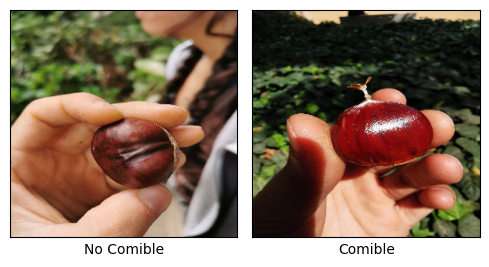

In [4]:
show_imgs(imgs, labels)

In [ ]:
from tensorflow.keras.models import Model

# el modelo es secuencial
model_path = './modelos/Castanas_Model_97.keras'
model_seq = keras.models.load_model(model_path)

# necesario para reemplazar la última capa Dense(1) por un linear
inputs = model_seq.inputs
outputs = model_seq.outputs
model = Model(inputs=inputs, outputs=outputs)

# model.summary()

In [80]:
pred = model.predict(imgs)
pred = np.floor(pred + 0.5).reshape(1,-1).astype('int')
print(labels[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
[['No Comible' 'Comible']]


# Lime

In [7]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [ ]:
explicacion0 = explainer.explain_instance(
    image=imgs[0],
    classifier_fn=model,
    top_labels=1,
    hide_color=0,
    num_samples=2000,
)
explicacion1 = explainer.explain_instance(
    image=imgs[1],
    classifier_fn=model,
    top_labels=1,
    hide_color=0,
    num_samples=2000,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

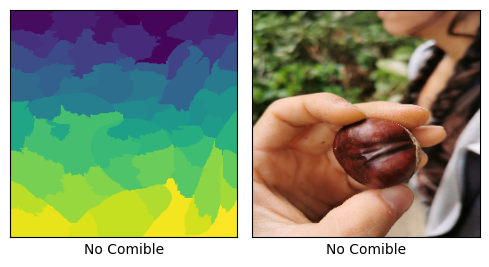

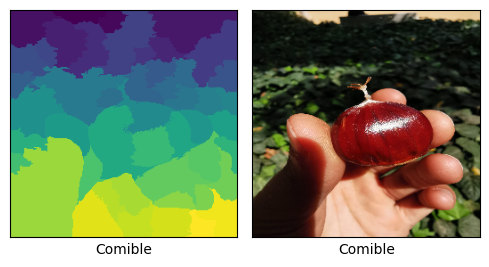

In [24]:
show_imgs([explicacion0.segments, imgs[0]], labels=[labels[0], labels[0]])
show_imgs([explicacion1.segments, imgs[1]], labels=[labels[1], labels[1]])

In [64]:
temp0, mask0 = explicacion0.get_image_and_mask(
    label=explicacion0.top_labels[0],
    positive_only=False,
    num_features=2,
    hide_rest=False,
)
temp1, mask1 = explicacion1.get_image_and_mask(
    label=explicacion1.top_labels[0],
    positive_only=False,
    num_features=2,
    hide_rest=False,
)

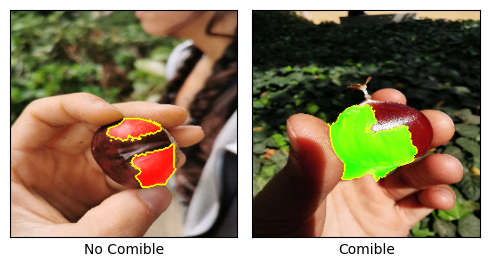

In [65]:
show_imgs([ mark_boundaries(temp0, mask0), mark_boundaries(temp1, mask1)], labels)

# Máxima Activación

In [100]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

In [81]:
act_max = ActivationMaximization(model, model_modifier=ReplaceToLinear())

In [ ]:
img_gen1 = act_max(BinaryScore(1), input_range=(0, 255))[0].numpy()
img_gen0 = act_max(BinaryScore(0), input_range=(0, 255))[0].numpy()

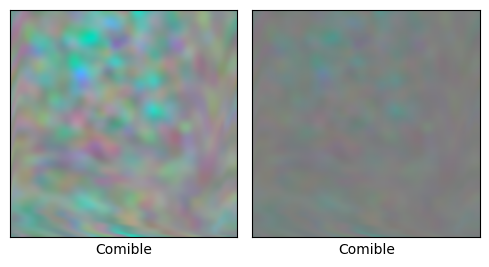

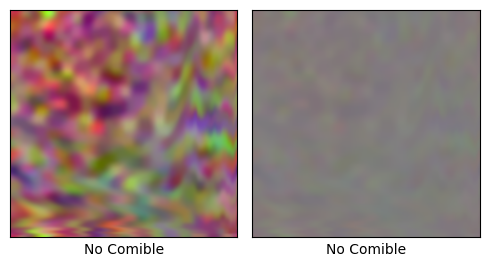

In [ ]:
img_norm = ((img_gen1 - img_gen1.min()) / (img_gen1.max() - img_gen1.min()))
img_norm0 = ((img_gen0 - img_gen0.min()) / (img_gen0.max() - img_gen0.min()))
show_imgs([img_norm, img_gen1.astype('uint8'),], [labels[1], labels[1]])
show_imgs([img_norm0, img_gen0.astype('uint8'),], [labels[0], labels[0]])